# Статистика, прикладной поток
## Практическое задание 1

В данном задании вы изучите свойства метода Монте-Карло, сравнив его с методом прямоугольков. Также с помощью метода Монте-Карло вы решите задачу, которая возникает при составлении проекта по разработке нефтяного месторождения. Знания физики или экономики не требуются. В последней задаче вы потренируетесь работать с библиотекой `pandas`.

**Правила:**

* Дедлайн **29 сентября 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[S19] Фамилия Имя - задание 1"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `1.N.ipynb` и `1.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него. Правила оформления смотрите в презентации с первого практического занятия.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 - 10 баллов
* Задача 2 - 10 баллов
* Задача 3 - 7 баллов
* Задача 4 - 15 баллов
* Задача 5 - 7 баллов

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

%matplotlib inline

-----

## Задача 1.
Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [2]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]
# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [3]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)
        uniform = [sps.uniform(low[i], high[i] - low[i]) for i in range(dim)]
        # сгенерировали равномерные распределения
        dots = np.array([uniform[i].rvs(n) for i in range(dim)]).T
        # dots - случайные точки, в которых будем вычислять функцию
        diff = high - low # Длины каждого отрезка
        # вычисление интеграла
        return np.prod(diff) / n * f(dots).sum()
    
    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        n_rounded =  int(np.power(n, 1./dim)) # количество точек, в которых вычисляем функцию
        diff = (high - low) / n_rounded # длины отрезков разбиения
        # для каждой размерности нашли центры отрезков разбиения 
        centers_of_ranges = np.array([(np.linspace(low[i], high[i], n_rounded + 1)[0:(n_rounded)] + diff[i]/2.) for i in range(dim)])
        centers = np.meshgrid(*centers_of_ranges)  # * передает наш массив как несколько аргументов
        f_vals = f(np.stack(centers).reshape(dim, -1).T) # Получили dim-мерные точки и вычислили функцию в них
        
        return f_vals.sum() * np.prod(diff)
    
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }

Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов?

In [4]:
square_sum = lambda x: np.sum(x**2, axis=1)

In [5]:
%%time
Integrator.integrate(square_sum, [0, 3], [1, 4], 1000000)

CPU times: user 20.5 ms, sys: 36.7 ms, total: 57.2 ms
Wall time: 56.5 ms


12.666666500000002

In [6]:
%%time
Integrator.integrate(square_sum, [0, 3], [1, 4], 1000000, method="monte_carlo")

CPU times: user 57.4 ms, sys: 8.21 ms, total: 65.6 ms
Wall time: 65.2 ms


12.670667566699391

***Вывод:*** Истинное же значение интеграла равно $12.(6)$. Заметим, что при меньшем времени работы (в 1.5-2 раза) метод прямоугольников работает точнее, чем метод Монте Карло в повторном интеграле. Значит, вполне возможно, в размерности < 3 метод прямоугольников можно использовать, и он будет выигрывать у метода Монте-Карло.

С чем это может быть связано? Размерность <= 2 позволяет нам брать все равно как минимум $\sqrt(n)$ точками в каждом направлении, что является (при $1000000$ запусков достаточно большим числом). И как известно из асимптотики скорости сходимости, для достаточно хорошей функции $f$ скорость сходимости $ O(\frac{1}{n^2}) $ в одномерном случае. В двумерном скорость сходимости будет уже не лучше$ O(\frac{1}{n}) $, что выше скорости сходимости метода Монте-Карло $ O(\frac{1}{\sqrt(n)}) $.

-----

## Задача 2.
Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее. 

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n = d \times 1000$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла.

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

Для Вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [7]:
max_dim = 8

def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
        
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)      
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        plt.legend(fontsize=14)

Заметим, что функция $ f(x) $ из нашей задачи симметрична относительно любого $ n $. Расписав наш интеграл в сумму интегралов, по линейности и симметричности получим: 
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i = \sum_{i=1}^d \int\limits_0^1 ... \int\limits_0^1 x_i^2 \prod_{i=1}^{d}dx_i = \sum_{i=1}^d \frac{1}{3} \cdot x_i^3 \cdot \prod_{j=1, j != i}^{d}x_i, x_k = 1 \forall k =  \sum_{i=1}^d \frac{1}{3} = \frac{d}{3}$$
Нужная функция по счастливому стечению обстоятельств уже была реализована в первом задании. Определим аргументы графиков.

In [8]:
square_sum = lambda x: np.sum(x**2, axis=1) # Та самая функция
low = np.zeros(max_dim) 
high = np.ones(max_dim)
theoretical_value = np.array([(d + 1)/3 for d in range(max_dim)]) 
n_list = np.arange(1000,8000,100)

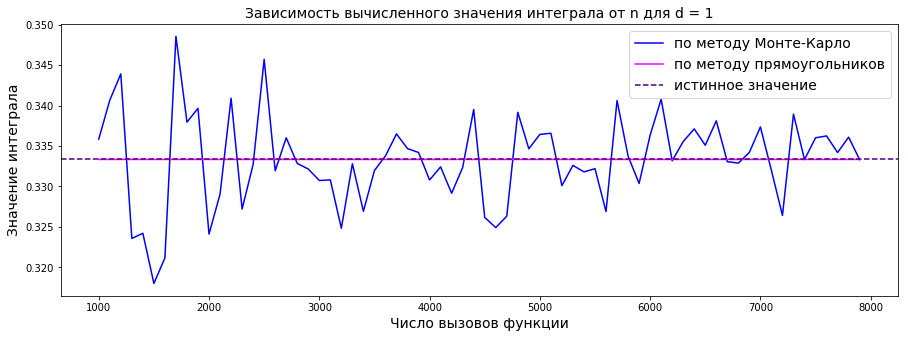

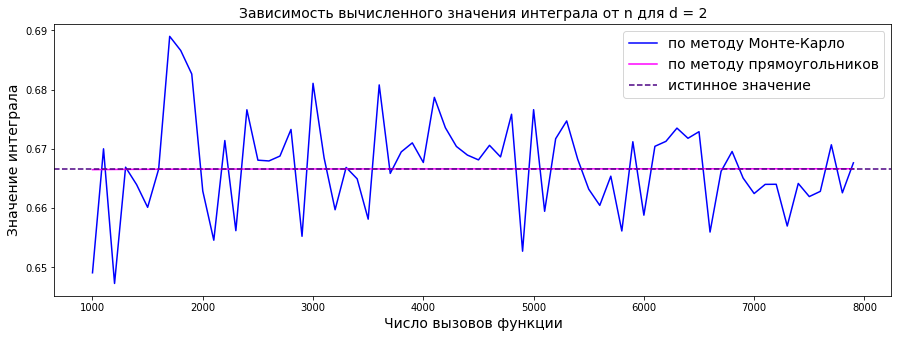

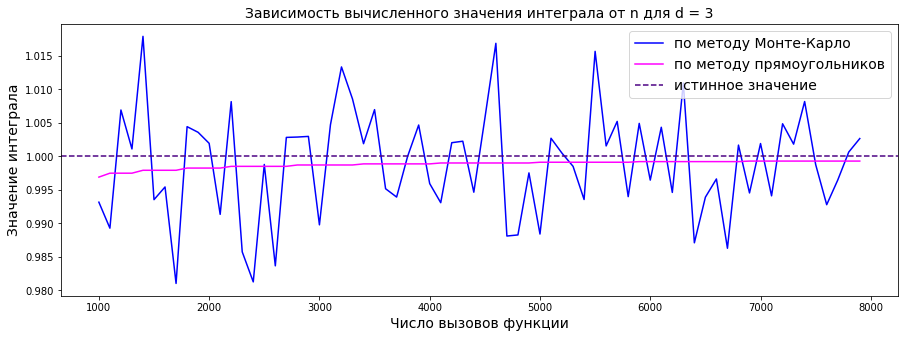

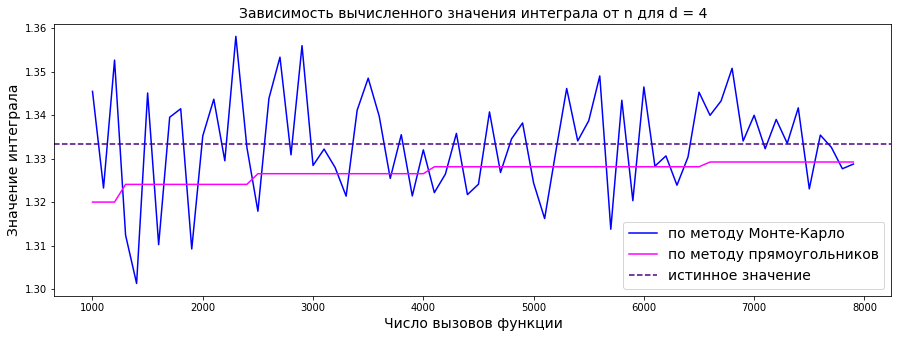

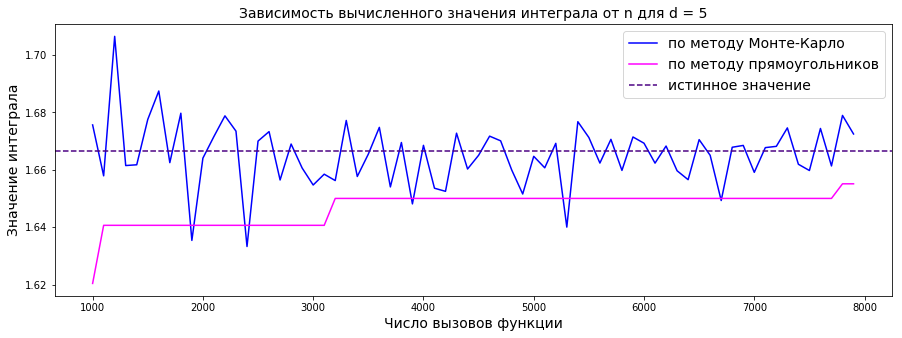

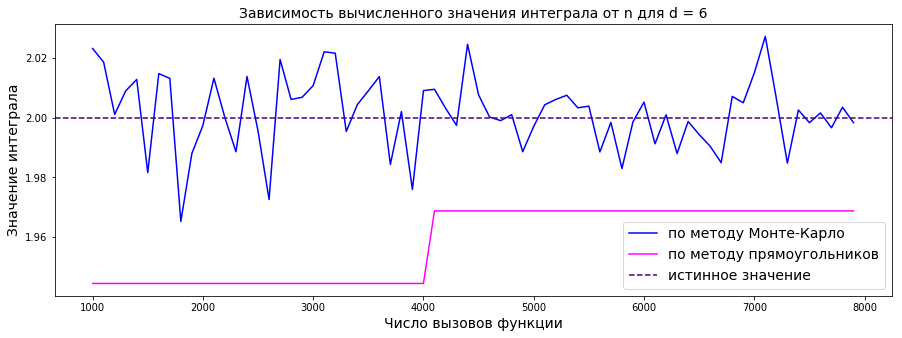

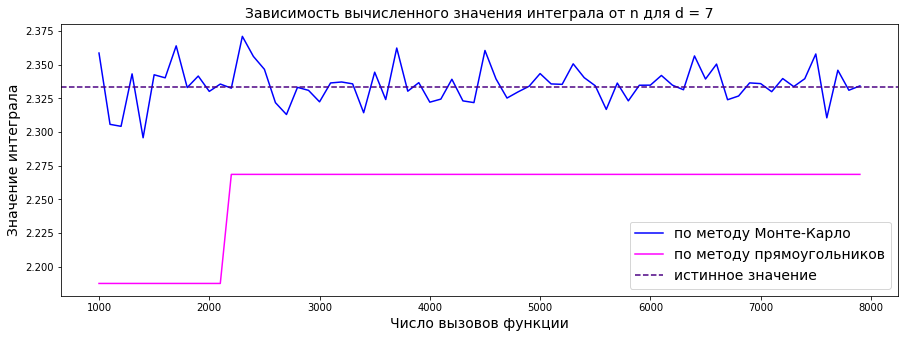

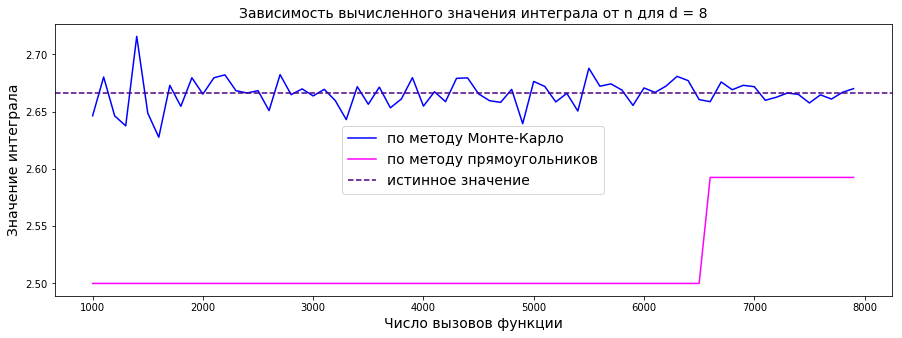

In [9]:
plot_convergence(square_sum, low, high, n_list, theoretical_value, max_dim)

С чем связано такое поведение графиков?

Сравните результаты с предыдущей задачей.

**Вывод:** Как мы видим, скорость сходимости метода Монте-Карло не сильно зависит от размерности (величина отклонения максимального от истинного значения не превышала 0.05. При этом, при большой размерности, например 8, величина отклонения стала больше 0.15. Это связано с тем, что при повышении размерности по каждой координате берется лишь $ n^{1/d} $ точек. И получается, что при размерности даже выше 4 и при количестве испытаний равном 10000 наш метод выберем <= 10 точек по каждой координате, что, очевидно, дает существенную погрешность. И кадый следующий интеграл в качестве подинтегральной функции рассматривает уже вычисленную с ее ошибкой. И так $n - 1$ раз. В предыдущей же задаче размерность 2 все равно оставляла большое количество точек, а ошибки при подсчете функции оказывали меньшее влияние на последующие интегралы. Метод Монте-Карло же - вероятностный. И в качестве точек берет совершенно рандомные. Можно сказать, он делит наше множество на $n$ частей, и для каждой из нее считает интеграл. Да и скорость сходимости его основана на ЦПТ, и зависит от размерности не $n^{2/d}$ образом.

-----

## Задача 3.
Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

***Ответ:***

1. В методе Монте-Карло из-за того, что по каждой компоненте у нас равномерное распределение, то из значимой части (где функция отлична от ($0+\epsilon$), ведь экспонента быстро убывает) будет выбрано в среднем доля элементов, равная $\frac{b-a}{length}$ элементов, и чем больше пределы интегрирования, тем меньше эта доля, а значит и вклад подобных "частичных интегралов"  в наш. Из-за чего значение интеграла может сильно уменьшиться. Где отрезок значимой части равен $[a,b]$, а length это длина отрезка интегрирования.

2. Так как метод прямоугольков делит предел по каждой компоненте на $n^{1/5}$ равныхчастей, при выборе слишком больших пределов в вычислении суммы будет слишком много слагаемых (из суммы значений функций), которые вносят почти нулевой вклад (т.к. $e^{-x}$ быстро убывает к нулю при $ x \rightarrow +\infty $), при этом значение значимой части будет вычислено совсем не точно.

В этой задаче нельзя использовать циклы. Решите задачу двумя способами:
1. Через функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html"> `numpy.vectorize`</a>.
2. Используя только простые веторно-матричные операции в `numpy`.

Оба способа имеют свои преимущества и недостатки. Перечислите их. Подсказка: рассмотрите большое $n$ -- число вызовов функции.

Пример использования функции `numpy.vectorize`:

In [10]:
def vector_function(x):
    """Получает на вход вектор некоторой длины n, возвращает число.
    Сигнатуру можно записать как (n)->()"""
    return x.sum()


f = np.vectorize(vector_function, signature="(n)->()")

In [11]:
arg = np.arange(10).reshape(-1, 2)
arg

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [12]:
f(arg)  # вычисляет суммы по строкам

array([ 1,  5,  9, 13, 17])

Реализуем нужные нам функции:

In [13]:
def vector_exp(x, A=np.eye(5)): # с помощью vectorize
    #if (A == np.eye(5)).all():
    return np.exp(-np.dot(x, x.T))
    #else:
    #    return np.exp(-np.dot(x, A).dot(x.T))
           
good_exp = np.vectorize(vector_exp, signature="(n)->()") # теперь массив x будет покомпонентно работать в функции.

In [14]:
def simple_exp(x, A=np.eye(5)):
    # По умолчанию единичная матрица
    # Значит, для каждого вектора x, степень экспоненты равна сумме квадратов компонент.
    # По правилам умножения матриц, x*x^T = сумма квадратов компонент.
    # А это как раз и есть диагональные элементы матрицы.
    values = np.array([np.dot(x[i], x[i].T) for i in range(len(x))])
    return np.exp(np.dot(-1, values))

Какова скорость работы первой функции?

На вход ей подается матрица $MxN$ и функция выполняется для каждой строки этой матрицы (то есть вызывается M раз). Каждая такая операция занимает $N^2$ операций на первое умножение и еще $N$ операций на второе. Т.е. выполняется порядка $M \cdot N^2 + M \cdot N$ операций. Для единичной матрицы сложность была бы линейной от N (ибо мы знаем, что тогда получится просто сумма квадратов компонент).

Какова скорость работы второй функции?

В моем исполнении - такая же. 

При этом, код первой

***Точное значение интеграла (при A = E):*** $\pi^\frac{d}{2}$, т.е. при $d$ = $5$ $\pi^\frac{5}{2}$

Посчитаем значение интеграла с пределами внутри области $[-5, 5]^5$ первой функцией:

In [15]:
%%time
num_points = 1000000
i = Integrator()
limits = [[-5] * 5, [5] * 5]
m_value = i.integrate(good_exp, limits[0], limits[1], num_points, method="monte_carlo")
r_value = i.integrate(good_exp, limits[0], limits[1], num_points)
print("Значение, полученное методом Монте-Карло при {} точках: {}".format(num_points, m_value))
print("Значение, полученное методом прямоугольников при {} точках:: {}".format(num_points, r_value))
print("Истинное значение: {}".format(np.pi ** (5./2)))

Значение, полученное методом Монте-Карло при 1000000 точках: 16.773019228173066
Значение, полученное методом прямоугольников при 1000000 точках:: 17.493418367284345
Истинное значение: 17.493418327624862
CPU times: user 8.77 s, sys: 40.8 ms, total: 8.82 s
Wall time: 8.8 s


Посчитаем второй:

In [16]:
%%time
num_points = 1000000
i = Integrator()
limits = [[-5] * 5, [5] * 5]
m_value = i.integrate(simple_exp, limits[0], limits[1], num_points, method="monte_carlo")
r_value = i.integrate(simple_exp, limits[0], limits[1], num_points)
print("Значение, полученное методом Монте-Карло при {} точках: {}".format(num_points, m_value))
print("Значение, полученное методом прямоугольников при {} точках:: {}".format(num_points, r_value))
print("Истинное значение: {}".format(np.pi ** (5./2)))

Значение, полученное методом Монте-Карло при 1000000 точках: 17.77301363502979
Значение, полученное методом прямоугольников при 1000000 точках:: 17.493418367284345
Истинное значение: 17.493418327624862
CPU times: user 2.76 s, sys: 75.6 ms, total: 2.83 s
Wall time: 2.25 s


**Вывод:** Метод прямоугольников при такой размерности все равно работает точнее вероятностного метода Монте-Карло. При этом, реализованная с помощью матричных операций функция работает в несколько раз быстрее.

Рассмотрим отношение интегралов $$F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx} $$
В чем его вероятностный смысл?

Вероятностный смысл этого отношения - ***функция вероятности***. Естественно, F всегда меньше или равна 1, что и натолкнула на эту мысль. Свойста функции распределения следуют из свойств интеграла.

-----

## Задача 4.
В заключении изучения методов численного интегрирования вам предлагается реальная практическая задача.

На основе http://ecsocman.hse.ru/data/819/759/1219/Monte_Karlo_dlya_analitikov.pdf
 	
Рассмотрим проект по разработке нефтяного месторождения. В основе модели проекта лежат предварительные данные о величине резервов месторождения.

*Замечание.* Знания физики или экономики не требуются.



*Формулировка задачи от заказчика:*
Общая задача анализа --- основываясь на величине запасов и проценте нефтеотдачи рассчитать NPV (чистая приведенная стоимость) проекта, а точнее, $0.1$-квантиль ее распределения.
Следующим этапом мы хотим использовать ее в качестве критерия оптимизации, то есть максимизировать такое значение NPV, которого мы можем достигнуть или превысить с $90\%$-й вероятностью, подобрав при этом оптимальное количество скважин на месторождении.



Предположим, что на месторождении есть $n$ скважин. Эти скважины добывают некоторую смесь, которая состоит из воды, нефти и различных примесей. Доля нефти из добытого материала называется <a href="https://ru.wikipedia.org/wiki/Нефтеотдача">коэффициентом нефтеотдачи</a> $k$. Мы будем считать, что этот коэффициент является одинаковым для всего месторождения и имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$.




**Добыча нефти скважиной за год**

<a href="http://vseonefti.ru/upstream/stadii-razrabotki.html">Разработка месторождения</a> включает три этапа:
1. фаза роста добычи --- период введения в работу новых скважин;
2. фаза плато: после достижения определенного уровня добычи, она некоторое время продолжается на постоянном уровне;
3. фаза снижения добычи --- период, когда темпы добычи экспоненциально снижаются с течением времени.


Для упрощения задачи мы пропустим два первых этапа и рассмотрим только последний.


Каждая скважина $j$ характеризуется параметром $q_j$ --- темп добычи из скважины, определяемый объемом вещества (смесь нефти, воды и др.), добываемого скважиной за сутки. Будем считать, что этот параметр является одинаковым для скважины в течении всего периода разработки и имеет нормальное распределение со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей. Темпы добычи для разных скважин считаются независимыми случайными величинами.

Соответственно, за год $t$ скважина добывает $Q_{tj} = 365 \cdot k \cdot q_j \cdot e^{-0.008 \cdot n \cdot (t-1)}$ тыс. баррелей нефти, где экспонента отвечает за снижение добычи с течением времени.
Всего за год $t$ на месторождении добывается $Q_t = \sum\limits_{j=1}^{n} Q_{tj}$ тыс. баррелей нефти.




**Прибыль**

Стоимость барреля нефти будем считать постоянной и равной $c = 70$ долларов за баррель. Однако, для расчета стоимости нужно учесть <a href="https://ru.wikipedia.org/wiki/Ставка_дисконтирования">ставку дисконтирования</a> --- процентная ставка, используемая для пересчета будущих потоков доходов в единую величину текущей стоимости (см. формулу далее). Обозначим ее $i$ и будем считать, что она имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$.

Стоимость добытой нефти за год $t$ составит (тыс. баррелей)
$$\frac{c \cdot Q_t}{(1+i)^{t-1}}.$$

Будем считать, что разработка месторождения прекращается, если за год на всем месторождении было добыто менее $100$ тыс. баррелей нефти. Последний год разработки обозначим $T$.




**Затраты**

Затраты на месторождение (кроме скважин) составляют $C_{\text{мест.}} = 200$ млн. долларов в год. Будем считать, что издержки на содержание скважины $j$ за весь период разработки имеют треугольное распределение (<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html">scipy.stats.triang</a>) c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов. Обозначим эти случайные величины $C^j_{\text{скв.}}$ и будем считать их независимыми.




**NPV**

Теперь мы можем написать формулу NPV
$$NPV = \sum\limits_{t=1}^T \frac{c \cdot Q_t}{(1+i)^{t-1}} - T \cdot C_{\text{мест.}} - \sum\limits_{j=1}^{n} C^j_{\text{скв.}}.$$




**Задание**

С помощью метода Монте-Карло требуется найти число $x$, при котором $$\mathsf{P}(NPV < x) = 0.1.$$

Количество итераций метода должно быть не менее $100\ 000$. На основе проделанных итераций оцените также среднее значение NPV и вероятность, с которой NPV будет положительна. Кроме того, постройте нормированную гистограмму значений NPV с помощью `plt.hist(values, bins=200, normed=True)`.



Перечислим еще раз все *случайные параметры*:
* Коэффициент нефтеотдачи $k$ имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$;
* $q_1, ..., q_{n}$ --- темпы добычи из скважин --- независимые нормальные случайные величины со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей;
* Ставка дисконтирования $i$ имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$;
* $C^1_{\text{скв.}}, ..., C^{n}_{\text{скв.}}$ --- затраты на каждую скважину --- независимые  случайные величины, имеющие треугольное распределение c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов. (используйте `sps.triang(loc=90, c=1/3, scale=30)`)

*Фиксированные параметры*:
* $n = 25$ скважин;
* $365$ дней в году;
* $c=70$ долларов за баррель --- стоимость нефти;
* $100$ тыс. баррелей --- объем добытой нефти за год, при котором разработка месторождения прекращается.
* $200$ млн. долларов в год --- затраты на месторождение.



-----

## Задача 5.

<img src="https://pp.userapi.com/c854528/v854528797/c62ce/FiPEibYUxJc.jpg" width="40%">

Netflix за последние 5-10 лет обзавелись большим количеством зрителей. С увеличением числа зрителей увеличилось и разнообразие шоу. Соответственно, перед аналитиками из киноиндустрии встала задача исследования данных с рейтингами различных сериалов.  
В данном задании вам предстоит провести визуальный анализ датасета **1000 Netflix Shows** (по состоянию на 11.06.2017) и сделать выводы.  



Описание признаков:
* `title` - название шоу.
* `rating` - рейтинг шоу. Например: G, PG, TV-14, TV-MA
* `ratingLevel` - описание рейтинговой группы и особенностей шоу.
* `release year` - год выпуска шоу.
* `user rating score` - оценка пользователей.


Загрузите данные, выполнив код ниже.

In [17]:
# код ниже менять нельзя (кроме пути до данных), просто запустите ячейку!
data = pd.read_csv("netflix_data.csv", encoding='cp437')
del data['ratingDescription'], data['user rating size']

Удалите из данных дупликаты. Сколько объектов удалено?

Сколько объектов осталось?

In [18]:
n = data[data.duplicated()].count()
df = data.drop_duplicates()
print("Удалено {} объектов".format(n[0]))

Удалено 500 объектов


In [19]:
print("Осталось {} объектов".format(df.count()[0]))

Осталось 500 объектов


Сколько рейтинговых групп представлено в данных?

In [20]:
rating_groups = set(df["rating"]) # Во множестве не бывает дубликатов
print("Рейтинговых групп: {}".format(len(rating_groups)))

Рейтинговых групп: 13


Какие оценки пользователи ставят чаще? Постройте гистограмму оценок.

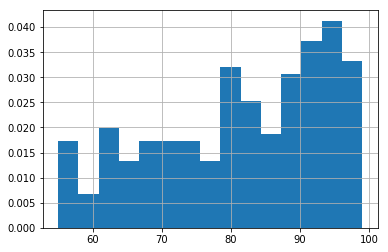

In [21]:
df["user rating score"].hist(density=True, bins=15)

***Вывод:*** В целом, видно, что пользователи ставят оценки не ниже 50. При этом больше половины пользователей оценивает шоу на более чем 80 процентов. Оценки ниже 70 бывают реже как минимум в два раза.

Выведите основную информацию об оценках пользователей: среднее, стандартное отклонение, минимум, максимум, медиана. Отличаются ли медиана и среднее? Могут ли данные характеристики значительно отличаться? Почему?

In [22]:
df["user rating score"].describe()

count    256.000000
mean      81.398438
std       12.730904
min       55.000000
25%       71.000000
50%       83.500000
75%       93.000000
max       99.000000
Name: user rating score, dtype: float64

In [23]:
print("Медиана: {}".format(df["user rating score"].median()))

Медиана: 83.5


***Ответ:*** Как видно, медиана и среднее (mean) не сильно отличаются. Но могли бы. Если бы пользователи ставили только оценки 100 и 70, то при среднем в 84 (< 85), медиана бы равняла 70, что было бы на 14 меньше среднего.

В какие годы были запущены шоу, представленные в датасете?

In [24]:
years = set(df["release year"]) # в сете же нет повторяющихся элементов - победа!
print(years)

{1940, 1976, 1978, 1982, 1986, 1987, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}


Постройте график, показывающий распределение количества запущенных шоу в зависимости от года. Наблюдается ли рост? Есть ли выбросы?

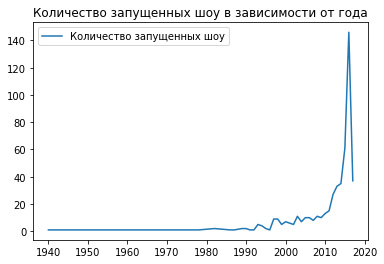

In [25]:
shows_for_year = df.groupby(['release year'],as_index=False).count() 
# as_index=False - чтобы столбец не пропадал
plt.plot(shows_for_year["release year"], shows_for_year["title"], label="Количество запущенных шоу")
plt.title("Количество запущенных шоу в зависимости от года")
plt.legend()

***Вывод:*** Да, рост наблюдается с 2000го года. В ~2013м году количество шоу увеличилось еще в 2 раза. И как видно из графика, в 2016м году произошел выброс, выпустилось более 130 фильмов. В 2017м их количество стало немного отличным от 2015го.

Сравните среднюю оценку пользователей в 2016 со средней оценкой в 2017. Можно ли сделать вывод, что 2017 год успешнее для Netflix? ("Успешнее" значит, что пользователи в среднем ставили более высокие оценки)  
Ответить на этот вопрос вам поможет график, который вы построили выше.



In [26]:
mean_show_for_year = df.groupby(['release year'],as_index=False).mean()
print(mean_show_for_year[mean_show_for_year["release year"] > 2015])

    release year  user rating score
33          2016          84.313953
34          2017          88.125000


***Вывод:*** Как видно из графика выше, 2016й год являлся выбросом (из-за огромного числа шоу), поэтому делать выводы относительно успешности года для студии вряд ли можно. Если бы было сопоставимое количество фильмов, то да, 2017й год можно назвать более успешным. Сравнивать же выброс с обычным годом вряд ли законно.

Ниже представлены два графика, показывающие распределение шоу по рейтинговым группам. Какой тип графика визуально более интерпретируемый? ([Подсказка](https://sun9-40.userapi.com/c854228/v854228652/c754f/j6z5gMjJy2k.jpg))  
Постройтре самостоятельно график, который считаете более интерпретируемым. Сделайте вывод.

![Charts](https://pp.userapi.com/c852024/v852024281/1a53b1/jSOsBIhxK3U.jpg)

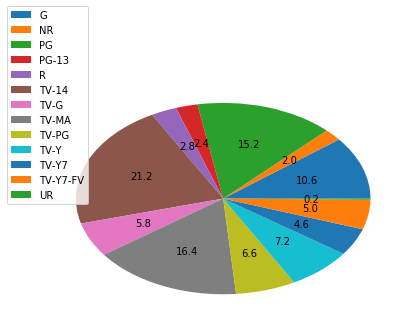

In [27]:
rating_count = df.groupby(['rating'],as_index=False, sort=True).count()
rating_groups_sort = rating_count.rating
rating_groups_count = rating_count.title
plt.pie(rating_groups_count, autopct='%.1f', radius = 1.1)
plt.legend(bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),loc = 'lower left', labels = rating_groups_sort)

***Вывод:*** Более половины телешоу принадлежат трем рейтингам: PG,TV-MA, TV-14. Значит, телешоу в этих рейтингах наиболее часто снимаемые. Телешоу в рейтинге UR наиболее непопулярные.

Составьте топ-13 самых высоко оцененных шоу. Выберите из данного топа шоу, которое вам наиболее нравится (либо используйте scipy.stats.randint). Обозначим это шоу N.
Ответьте на следующие вопросы:  
* Какое шоу является худшим по оценкам в рейтинговой группе, к которой принадлежит N?  
* Сколько шоу было выпущено в одном году с N?  
* Насколько бы изменилась средняя оценка шоу, выпущенных в одном году с N, если бы Netflix не запустили шоу N?

In [28]:
best_shows = df.fillna(0).sort_values("user rating score", ascending=True)[-13:] 
# Заменили все неизвестные рейтинги 0м, и выбрали 13 наиболее высоко оцененных.
best_shows

title rating  \
88              Finding Dory     PG   
2             Grey's Anatomy  TV-14   
3               Prison Break  TV-14   
27                 The Flash  TV-PG   
25        Marvel's Iron Fist  TV-MA   
72   Orange Is the New Black  TV-MA   
63            Criminal Minds  TV-14   
350                     Lost  TV-14   
10          Once Upon a Time  TV-PG   
64                   Friends  TV-14   
8           The Walking Dead  TV-MA   
62                Family Guy  TV-MA   
41            13 Reasons Why  TV-MA   

                                           ratingLevel  release year  \
88                              mild thematic elements          2016   
2    Parents strongly cautioned. May be unsuitable ...          2016   
3    Parents strongly cautioned. May be unsuitable ...          2008   
27   Parental guidance suggested. May not be suitab...          2016   
25                                                   0          2017   
72   For mature audiences.  May not be suitable for...          2016   
63   Parents strongly cautioned. May be unsuitable ...          2016   
350  Parents strongly cautioned. May be unsuitable ...          2010   
10   Parental guidance suggested. May not be suitab...          2016   
64   Parents strongly cautioned. May be unsuitable ...          2003   
8    For mature audiences.  May not be suitable for...          2015   
62   For mature audiences.  May not be suitable for...          2015   
41   For mature audiences.  May not be suitable for...          2017   

     user rating score  
88                98.0  
2                 98.0  
3                 98.0  
27                98.0  
25                98.0  
72                98.0  
63                98.0  
350               98.0  
10                98.0  
64                98.0  
8                 98.0  
62                98.0  
41                99.0

In [29]:
my_show = best_shows[best_shows.title == "Finding Dory"]

In [30]:
bad_show = df[df.rating == "PG"].sort_values("user rating score")[0:1]
bad_show # Но провал этого шоу не уберег звездные войны от новых фильмов и мультсериалов

title rating  \
504  Star Wars: The Clone Wars     PG   

                                           ratingLevel  release year  \
504  sci-fi action violence throughout, brief langu...          2008   

     user rating score  
504               57.0

In [31]:
year_count = df.groupby(['release year'],as_index=False, sort=True).count()
my_show_year_count = year_count[year_count["release year"] == int(my_show["release year"])]
print("Было выпущено {} фильмов".format(int(my_show_year_count["title"])))

Было выпущено 146 фильмов


In [32]:
year_mean = df[df["release year"] == int(my_show["release year"])].groupby(['release year'],as_index=False, sort=True).mean()
year_mean

release year  user rating score
0          2016          84.313953

In [33]:
films = df[df["release year"] == int(my_show["release year"])]
films = films.drop(films[films["title"] =="Finding Dory"].index)
films.groupby(['release year'],as_index=False, sort=True).mean()

release year  user rating score
0          2016          84.152941

Как видим, средний балл упал на 15 сотых процента.